In [42]:
import torch
import torchvision
import random


In [43]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/Users/hemanth/ENTER/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hemanth/ENTER/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [44]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [45]:
def get_cars(boxes, class_id):
    cars = []
    for i, box in enumerate(boxes):
        if class_id[i] in [3,8,6]:
            cars.append(box)
    return np.array(cars)


def compute_overlaps(parked_car_boxes, car_boxes):
    new_car_boxes = []
    for box in car_boxes:
        y1 = box[0]
        x1 = box[1]
        y2 = box[2]
        x2 = box[3]
        
        p1 = (x1, y1)
        p2 = (x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        new_car_boxes.append([p1, p2, p3, p4])
    overlaps = np.zeros((len(parked_car_boxes), len(new_car_boxes)))
    for i in range(len(parked_car_boxes)):
        for j in range(car_boxes.shape[0]):
            pol1_xy = parked_car_boxes[i]
            pol2_xy = new_car_boxes[j]
            polygon1_shape = shapely_poly(pol1_xy)
            polygon2_shape = shapely_poly(pol2_xy)

            polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
            polygon_union = polygon1_shape.union(polygon2_shape).area
            IOU = polygon_intersection / polygon_union
            overlaps[i][j] = IOU
    return overlaps


In [46]:
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO

In [47]:
def get_prediction(img_path, threshold=0.5, url=False):
  if url: # We have to request the image
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else:
    img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [48]:
import cv2
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [85]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=0.4, text_th=3, url=False):
  car_boxes = []
  masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
  if url:
    img = url_to_image(img_path) # If we have a url image
  else: # Local image
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    if(pred_cls[i]=='car'):
      car_boxes.append([pt1[0], pt1[1], pt2[0], pt2[1]])

      cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
      # cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i], car_boxes

In [86]:
img, pred_classes, masks, car_boxes = instance_segmentation('./cars6.jpeg', rect_th=1, text_th=1)


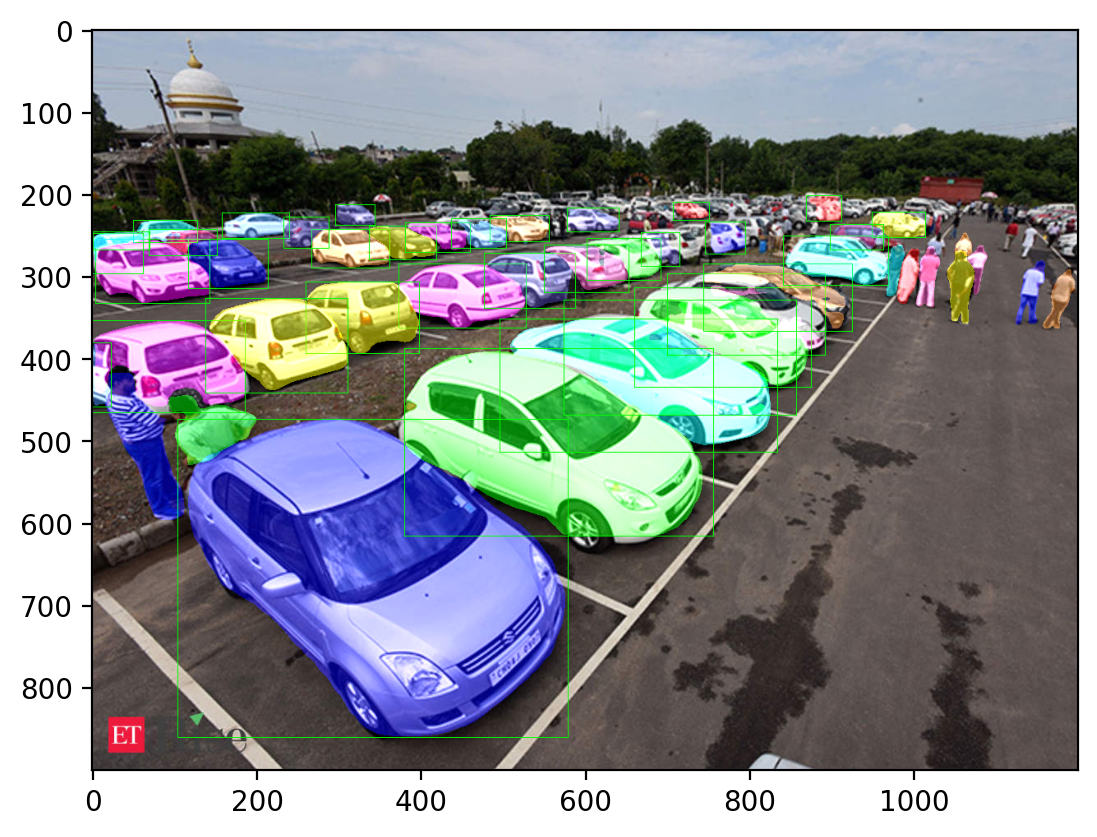

In [87]:
plt.imshow(img)

In [88]:
print(car_boxes[:2])

[[104, 473, 579, 860], [373, 284, 528, 362]]


['car', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person', 'car', 'car', 'car', 'car', 'car', 'person', 'person', 'car', 'person', 'car', 'person', 'car', 'person', 'car', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'person', 'car', 'car', 'car', 'car', 'car', 'car']
